# Project: Build a Traffic Sign Recognition Classifier

this notebook is structured in 4 parts

1. [Load data, data exploration and visualization](#part1)
2. [Deeplearning model design, training dataset preprocessing, balancing, augmentations and model training](#part2)
3. Performance evaluation and predictions
4. (Optional) visualization of the network state

---


## <a name="part1"></a> Part 1: load data, preprocessing, balancing and augmentations

In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pickle
import pandas as pd
from pandas.io.parsers import read_csv
import random
import imgaug.augmenters as iaa
import imgaug as ia
import cv2 as cv
print("cv version (tested on 4.5.1) is {}".format(cv.__version__))
import tensorflow as tf
print("tf version (tested on 2.4.1) is {}".format(tf.__version__))


cv version (tested on 4.5.1) is 4.5.1
tf version (tested on 2.4.1) is 2.4.1


---

### Load the dataset & check its integrity

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA BELOW CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [100]:
training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

### Dataset Summary & Exploration



In [4]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of a traffic sign image
index = random.randint(0, len(X_train))
image = X_train[index]
image_shape = image.shape

# How many unique classes/labels there are in the dataset.
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = len(class_counts)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of some image examples

There are three visualization functions. 

1. One 'plot_sample_of_each' shows a sublot of 35 color images from the training dataset each to each image. Each image is unique and there is only one image per class. This method is used to produce a picture for the writeup.

2. The method 'plot_sign_count_bar' takes as input the signnames and the number of sings to produce a sortet bar plot that shows the distribution of the different classes in terms of number of images. This method is useful to check how augmentation techniques shape the distribution of images. Applied to the original datasets (train, valid and test) show that they all show a similar distribution among the classes and they are not balanced.

3. the method 'plot_samples_from_all_classes' shows a sample of random images per each class (10 by default). This method is useful to observe the datasets and to check the overall impact of the image filters.


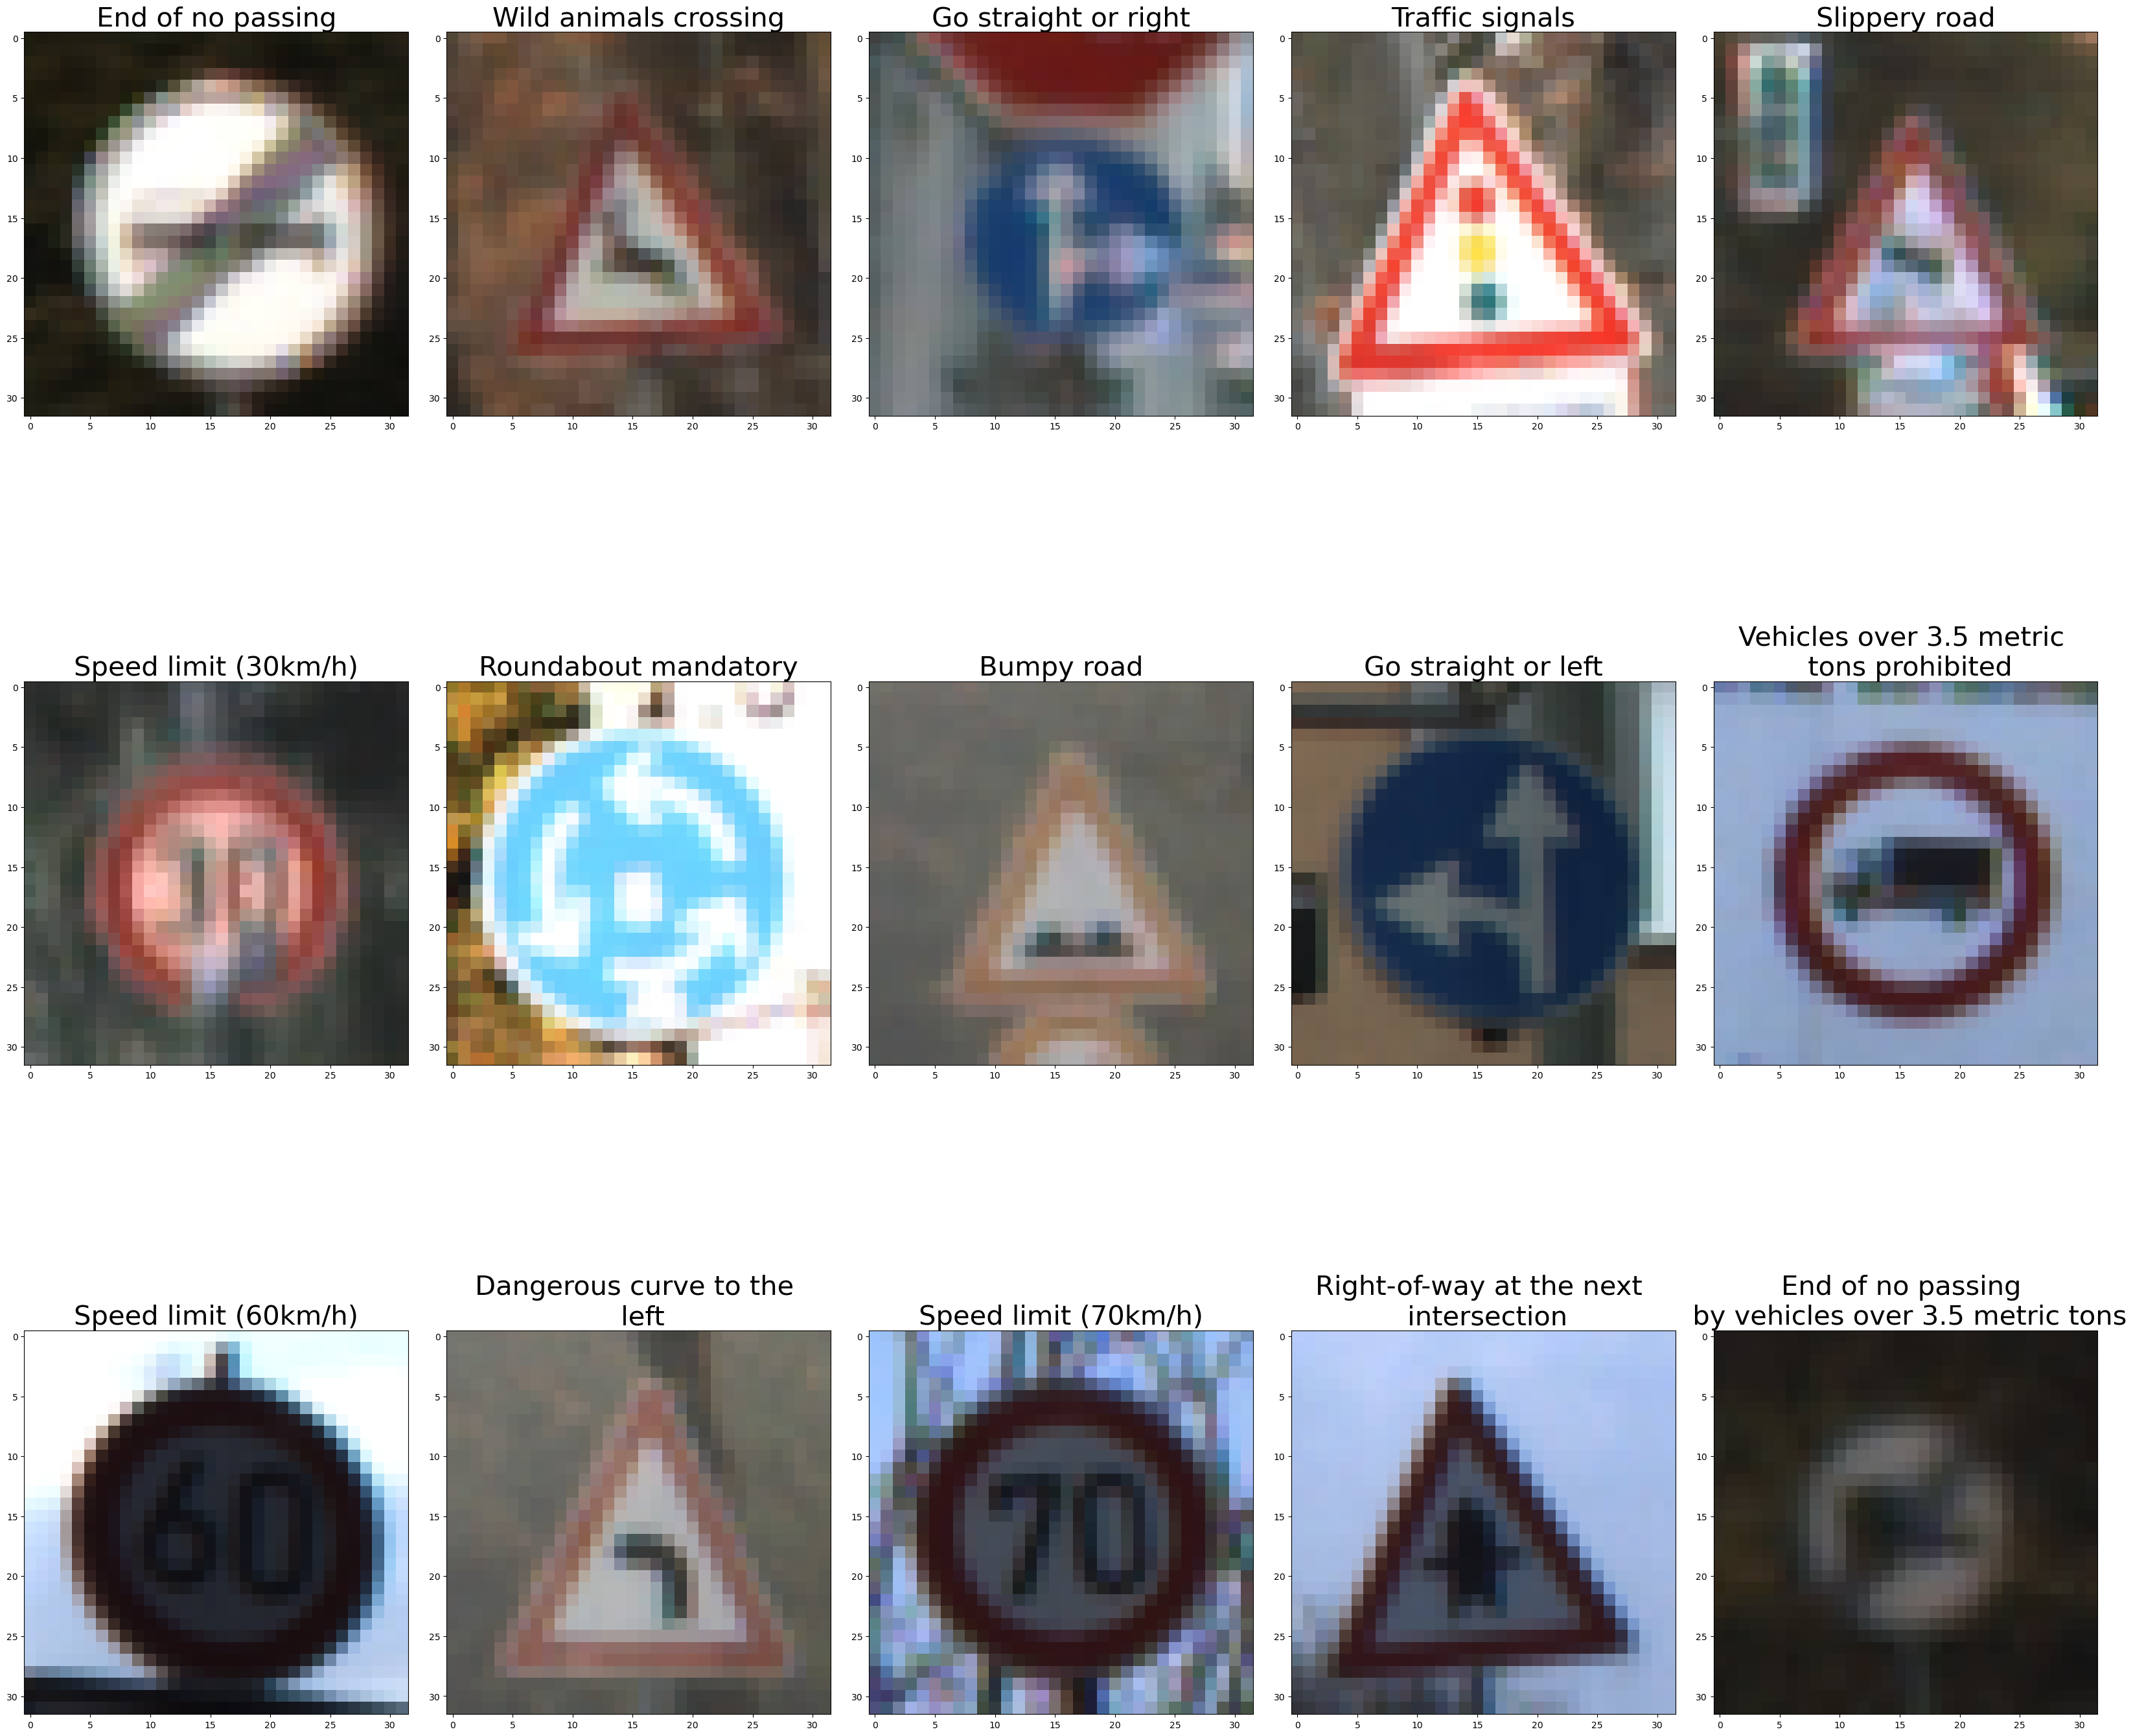

In [106]:
def plot_sample_of_each(rows=3,columns=5):
    """
    Plots a subplot with rows*columns samples of images from the training dataset
    :return: saves a file
    """
    sign_names = pd.read_csv('signnames.csv')
    random_unique_sign_img = []
    sign_name_title = []
    df = pd.DataFrame({'sign':list(y_train)})
    classes = list(df.sign.unique())
    for sign in classes:
        
        unique_sign = df[df['sign']==sign].sample(n=1)
        random_unique_sign_img.append(X_train[unique_sign.index[0]])
        title = sign_names[sign_names['ClassId']==sign]['SignName'].values[0]
        if len(title.split())<5:
            sign_name_title.append(title)
        else:
            two_l = title.split()[0:4]
            two_l.extend('\n')
            two_l.extend(title.split()[4:])
            sign_name_title.append(' '.join(two_l))

    f, (axes) = plt.subplots(rows,columns, figsize=(32, 32)) 
    f.tight_layout()
    for i in range(rows):
        for j in range(columns):
            if(len(random_unique_sign_img)>0):
                axes[i][j].imshow(random_unique_sign_img.pop(0))
                axes[i][j].set_title(sign_name_title.pop(0),fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.05,hspace = 0.4,wspace = 0.1)
    f.savefig('writeup_images/Some_example_sings_{}x{}.png'.format(rows,columns),dpi=300, bbox_inches = "tight")
    
    
plot_sample_of_each(rows=3,columns=5)    



### Distribution of datasets

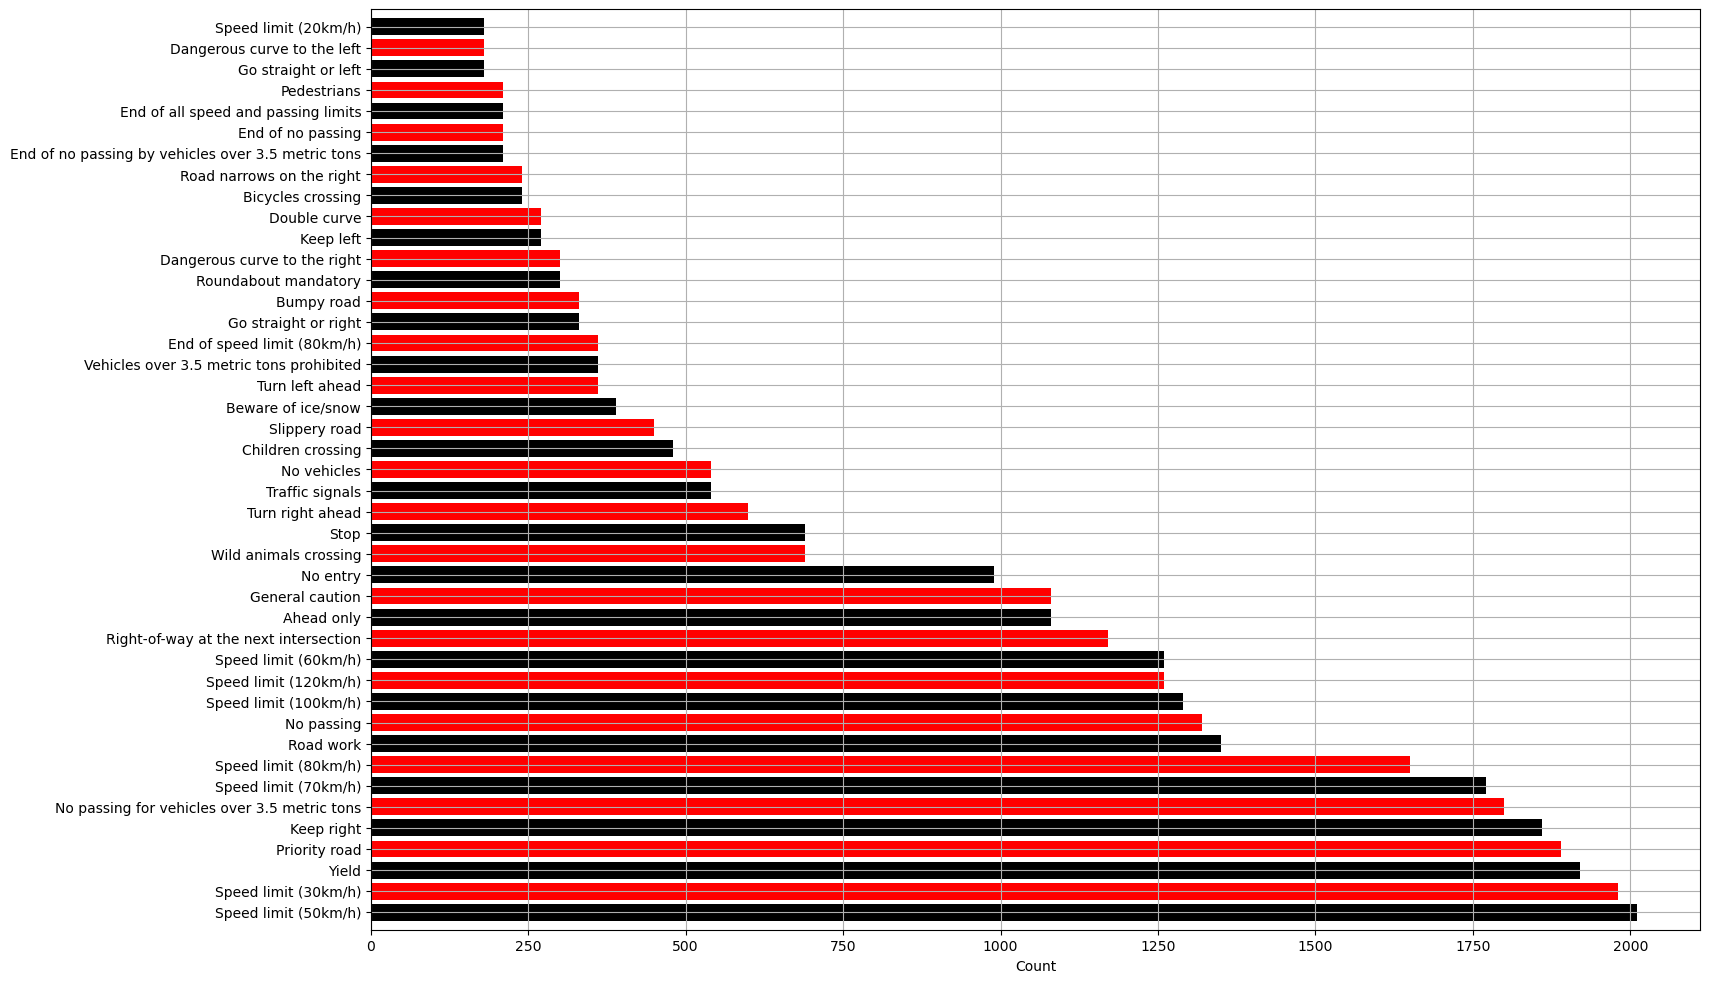

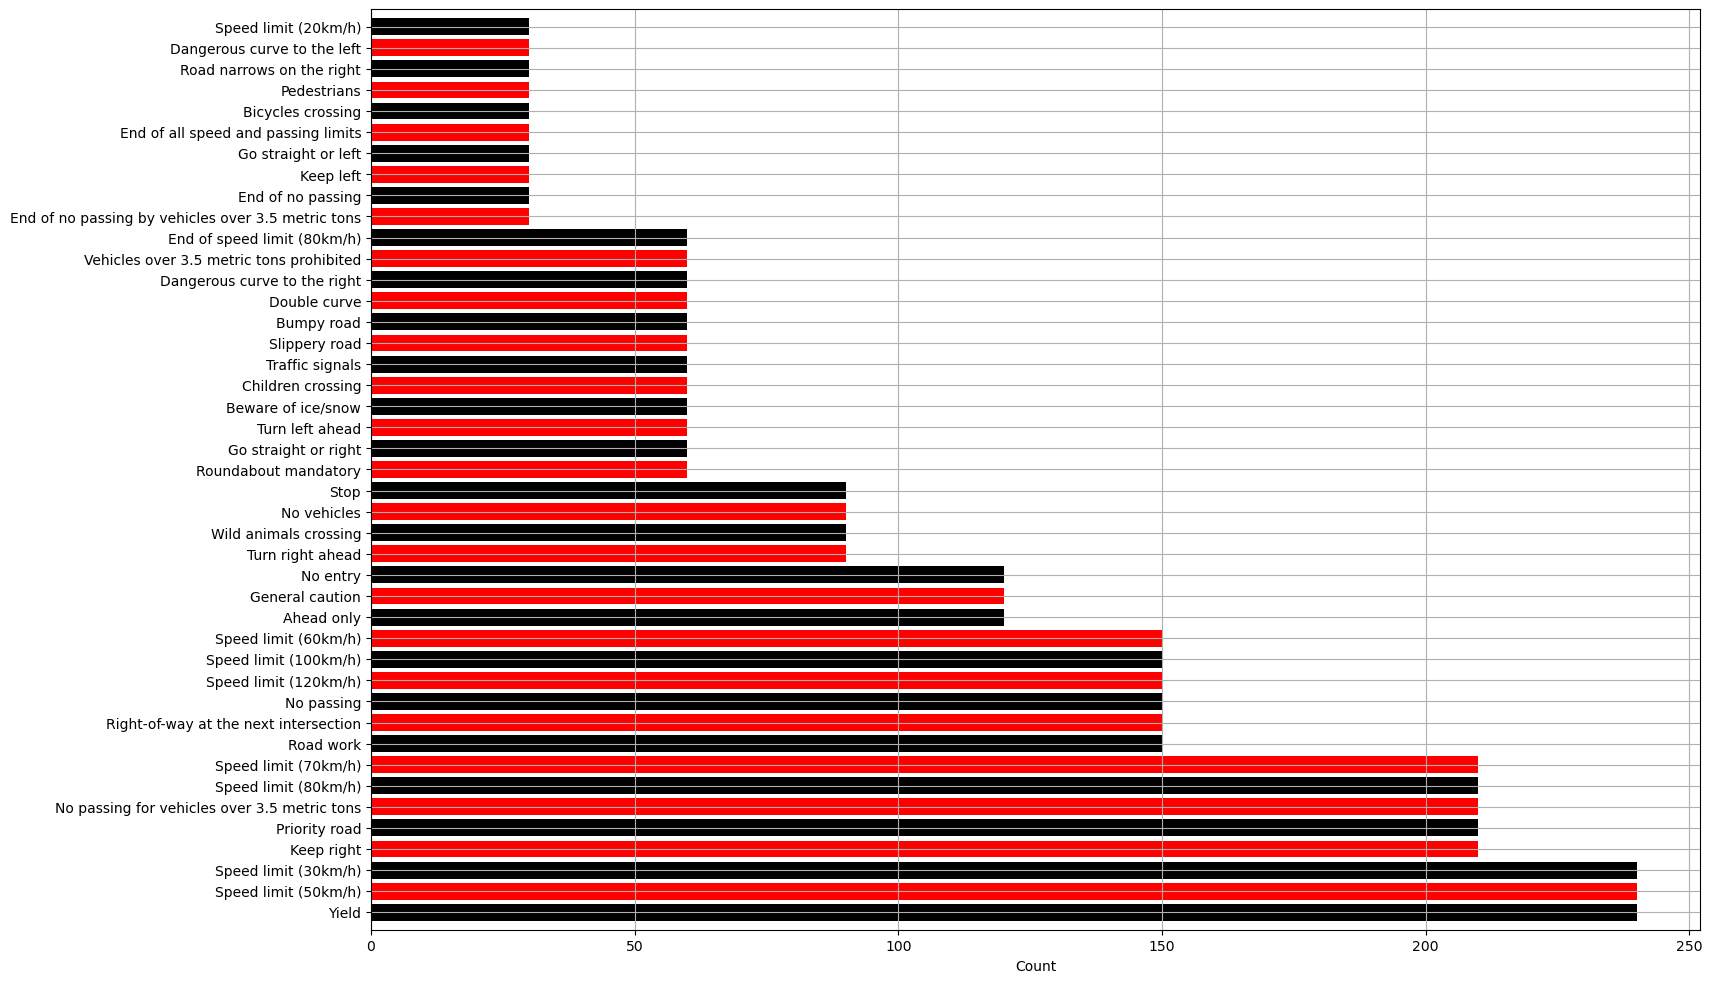

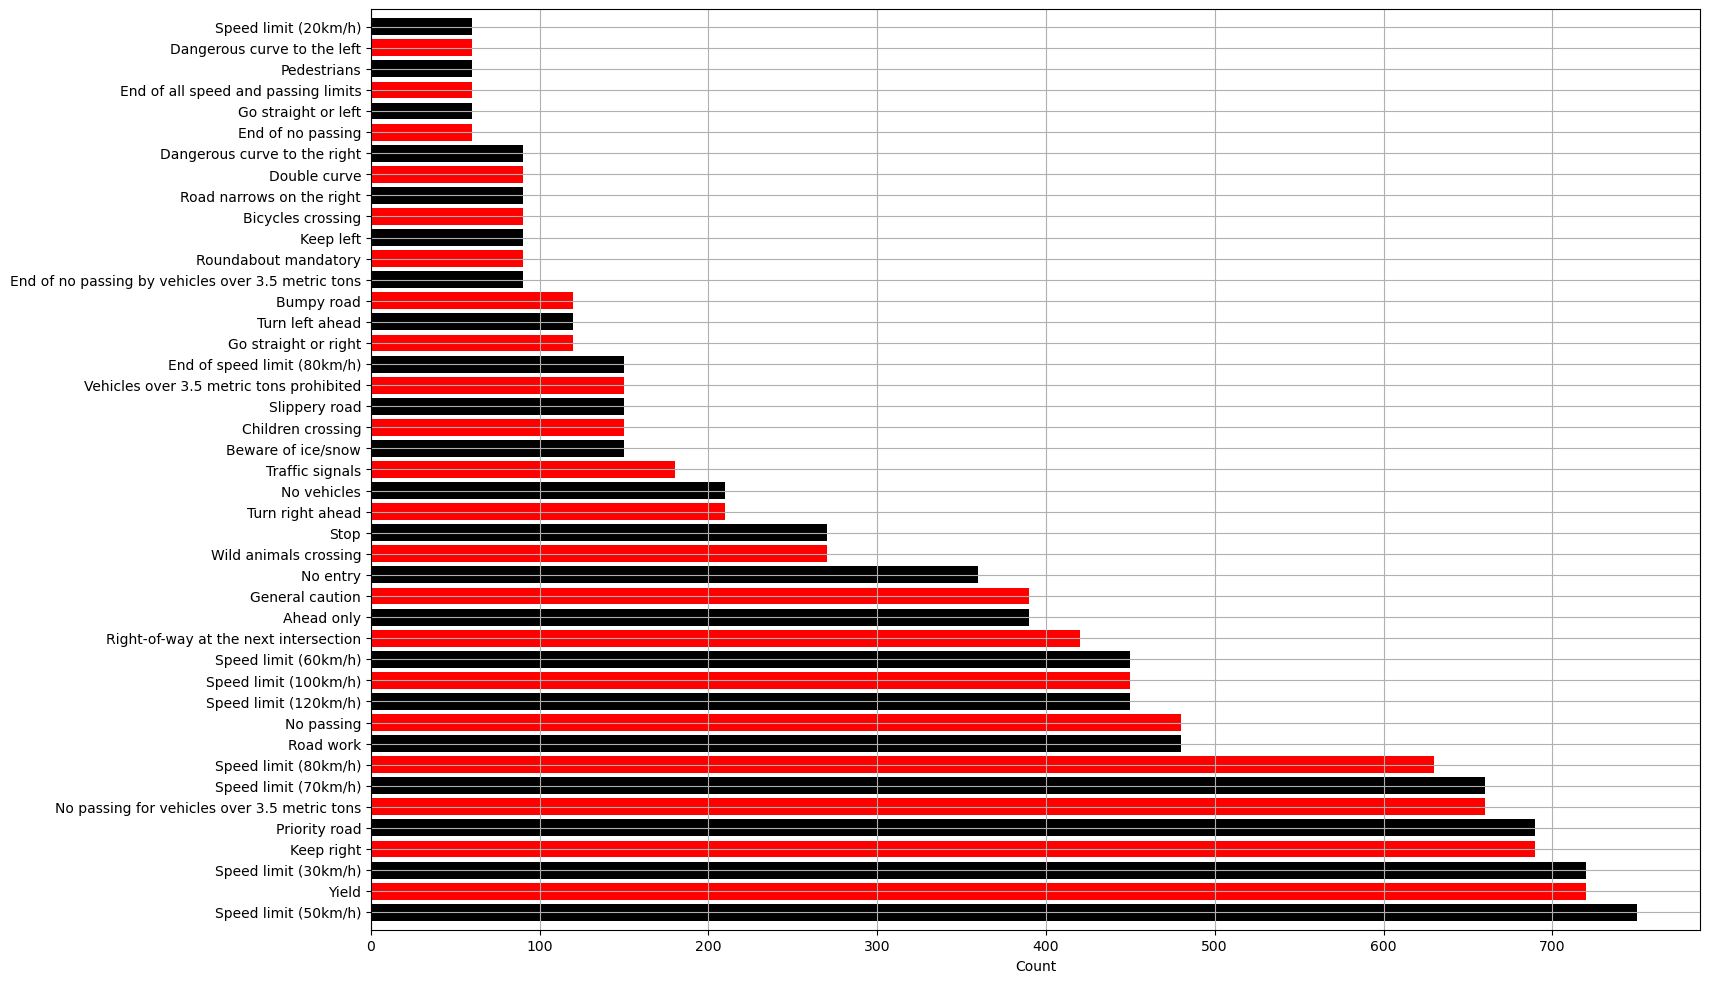

In [108]:

def plot_sign_count_bar(signnames,counter,dataset_name='Training'):
    """
    Creates and plot an horizontal bar plot
    :param signnames: list of names for the labels
    :param counter: amount of of pictures per class
    :param dataset_name: used as filename title
    :return: saves a png file
    """
    #put sign names and counters into a dict
    sign_dict = {}
    for s,c in zip(signnames,counter):
        sign_dict[s]=c
        
    #sort dict values for nicer visualization
    values = sorted(sign_dict.values())
    labels = sorted(sign_dict, key=sign_dict.get)

    #generate figure
    plt.rcdefaults()
    fig, ax = plt.subplots()
    plt.tight_layout()
    fig.set_size_inches(15, 10.5)
    plt.margins(y=0.01)
    plt.grid(True)
    ax.barh(range(len(sign_dict)), values, align='center')
    bars = plt.barh(range(len(sign_dict)), values, align='center',color=['black','red'])
    plt.yticks(range(len(sign_dict)), labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Count')
    fig.savefig('writeup_images/{}_data_distrib.png'.format(dataset_name),dpi=300, bbox_inches = "tight")
    
    
signnames = read_csv("signnames.csv").values[:, 1]

#visualizing and saving Training data distribution
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
plot_sign_count_bar(signnames,class_counts,dataset_name='Training')    
#visualizing and saving Validation data distribution
sign_classes, class_indices, class_counts = np.unique(y_valid, return_index = True, return_counts = True)
plot_sign_count_bar(signnames,class_counts,dataset_name='Validation')   
#visualizing and saving Test data distribution
sign_classes, class_indices, class_counts = np.unique(y_test, return_index = True, return_counts = True)
plot_sign_count_bar(signnames,class_counts,dataset_name='Test')   

Class 0: Speed limit (20km/h)                                180 samples


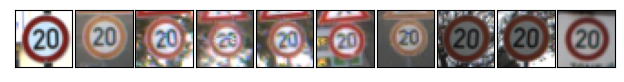

--------------------------------------------------------------------------------------

Class 1: Speed limit (30km/h)                                1980 samples


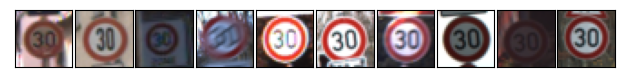

--------------------------------------------------------------------------------------

Class 2: Speed limit (50km/h)                                2010 samples


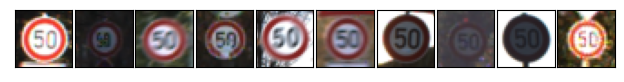

--------------------------------------------------------------------------------------

Class 3: Speed limit (60km/h)                                1260 samples


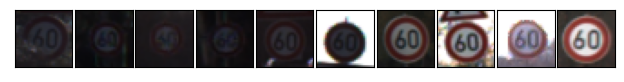

--------------------------------------------------------------------------------------

Class 4: Speed limit (70km/h)                                1770 samples


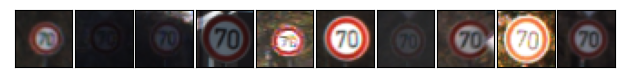

--------------------------------------------------------------------------------------

Class 5: Speed limit (80km/h)                                1650 samples


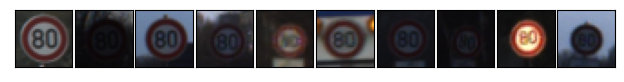

--------------------------------------------------------------------------------------

Class 6: End of speed limit (80km/h)                         360 samples


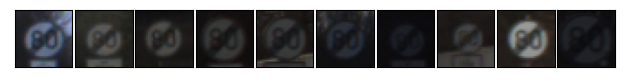

--------------------------------------------------------------------------------------

Class 7: Speed limit (100km/h)                               1290 samples


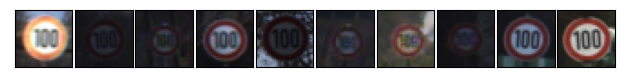

--------------------------------------------------------------------------------------

Class 8: Speed limit (120km/h)                               1260 samples


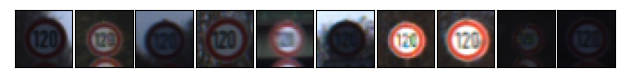

--------------------------------------------------------------------------------------

Class 9: No passing                                          1320 samples


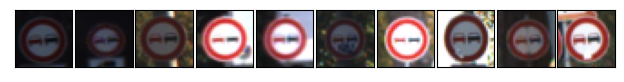

--------------------------------------------------------------------------------------

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


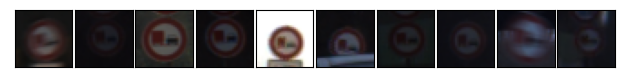

--------------------------------------------------------------------------------------

Class 11: Right-of-way at the next intersection               1170 samples


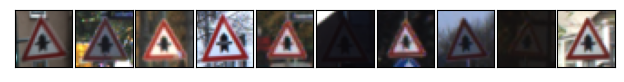

--------------------------------------------------------------------------------------

Class 12: Priority road                                       1890 samples


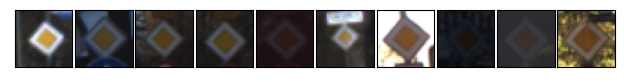

--------------------------------------------------------------------------------------

Class 13: Yield                                               1920 samples


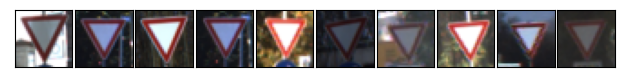

--------------------------------------------------------------------------------------

Class 14: Stop                                                690 samples


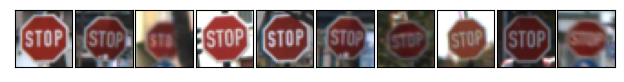

--------------------------------------------------------------------------------------

Class 15: No vehicles                                         540 samples


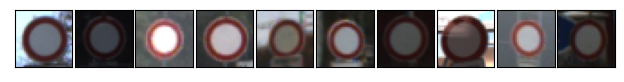

--------------------------------------------------------------------------------------

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


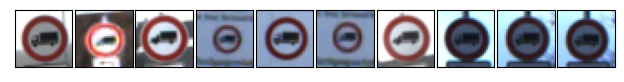

--------------------------------------------------------------------------------------

Class 17: No entry                                            990 samples


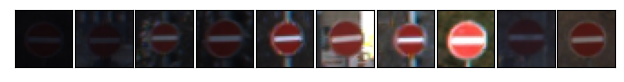

--------------------------------------------------------------------------------------

Class 18: General caution                                     1080 samples


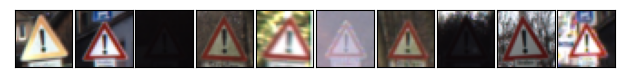

--------------------------------------------------------------------------------------

Class 19: Dangerous curve to the left                         180 samples


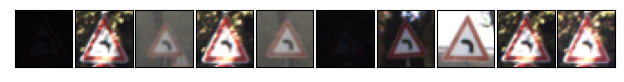

--------------------------------------------------------------------------------------

Class 20: Dangerous curve to the right                        300 samples


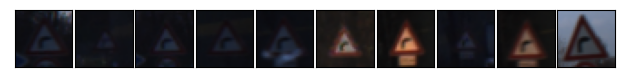

--------------------------------------------------------------------------------------

Class 21: Double curve                                        270 samples


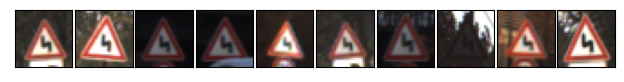

--------------------------------------------------------------------------------------

Class 22: Bumpy road                                          330 samples


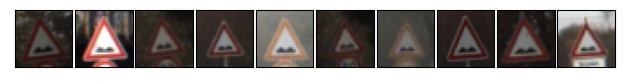

--------------------------------------------------------------------------------------

Class 23: Slippery road                                       450 samples


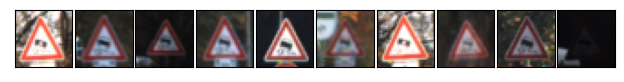

--------------------------------------------------------------------------------------

Class 24: Road narrows on the right                           240 samples


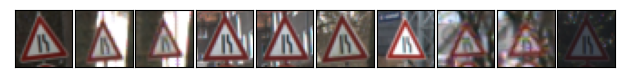

--------------------------------------------------------------------------------------

Class 25: Road work                                           1350 samples


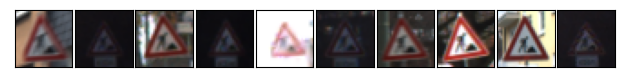

--------------------------------------------------------------------------------------

Class 26: Traffic signals                                     540 samples


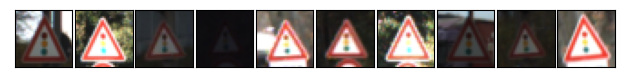

--------------------------------------------------------------------------------------

Class 27: Pedestrians                                         210 samples


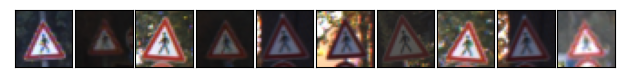

--------------------------------------------------------------------------------------

Class 28: Children crossing                                   480 samples


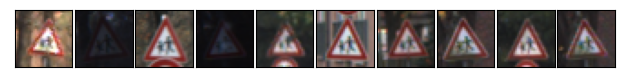

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing                                   240 samples


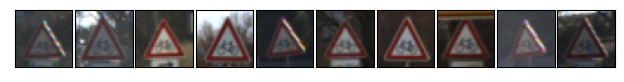

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow                                  390 samples


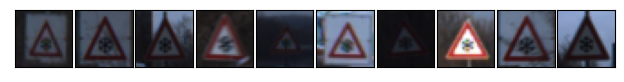

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing                               690 samples


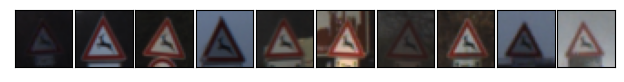

--------------------------------------------------------------------------------------

Class 32: End of all speed and passing limits                 210 samples


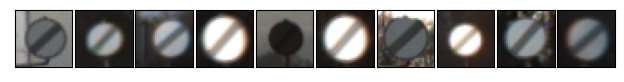

--------------------------------------------------------------------------------------

Class 33: Turn right ahead                                    599 samples


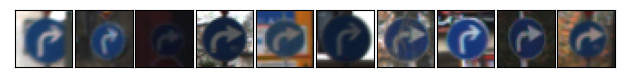

--------------------------------------------------------------------------------------

Class 34: Turn left ahead                                     360 samples


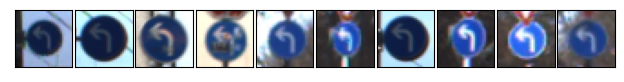

--------------------------------------------------------------------------------------

Class 35: Ahead only                                          1080 samples


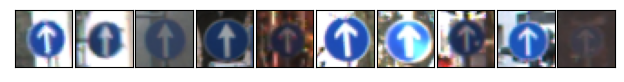

--------------------------------------------------------------------------------------

Class 36: Go straight or right                                330 samples


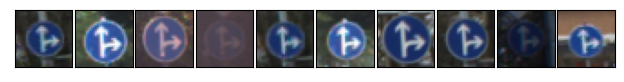

--------------------------------------------------------------------------------------

Class 37: Go straight or left                                 180 samples


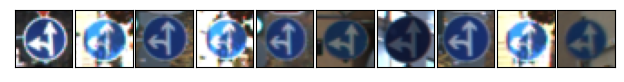

--------------------------------------------------------------------------------------

Class 38: Keep right                                          1860 samples


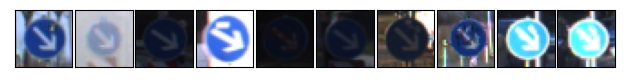

--------------------------------------------------------------------------------------

Class 39: Keep left                                           270 samples


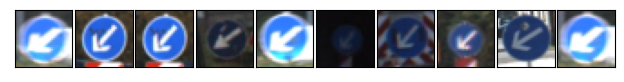

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory                                300 samples


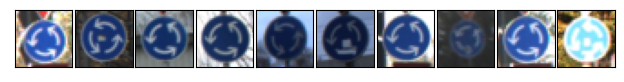

--------------------------------------------------------------------------------------

Class 41: End of no passing                                   210 samples


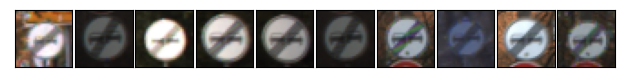

--------------------------------------------------------------------------------------

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


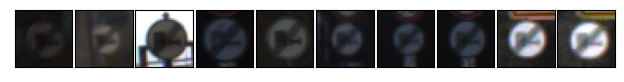

--------------------------------------------------------------------------------------



In [103]:
def plot_samples_from_all_classes(images,labels,n_samples=10,color='rgb', show_indices=False):
    """
    Plots some random examples per each class of images
    :param images: list images
    :param labels: list of numerical labels
    :param n_samples: number of samples per class
    :param color: default is rgb, valid alternative is gray
    :return: none
    """
    sign_classes, class_indices, class_counts = np.unique(labels, return_index = True, return_counts = True)
    df = pd.DataFrame({'sign':list(labels)})
    col_width = max(len(name) for name in signnames)
    for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
        print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
        fig = plt.figure(figsize = (6, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)        
        random_indices = df[df['sign']==c].sample(n=n_samples)
        random_indices = random_indices.index[:]
        for i in range(n_samples):
            axis = fig.add_subplot(1, n_samples, i + 1, xticks=[], yticks=[])
            if color == 'gray':
                axis.imshow(images[random_indices[i]],cmap='gray')
            else:
                axis.imshow(images[random_indices[i]])
        plt.show()
        if(show_indices):
            print("Image indices: {}".format(random_indices))
        print("--------------------------------------------------------------------------------------\n")

    

plot_samples_from_all_classes(X_train,y_train)



----

## <a name="part2"></a>Part 2: Deeplearning model design, data preprocessing, balancing, augmentations and model training

We designed and implemented a deep learning model that learns to recognize traffic signs. The model is trained and testd on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The model is also tested against some additional images that we personally took in Germany.

1. The network model
2. Conversion to greyscale
3. Training dataset balancing
4. Training dataset augmentations
5. Datasets normalization and distribution centering
6. Model training



### Model Architecture

The current model is a modified version of the the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81). 

The current implementation uses five hidden layers, three convolutional layers with increasing depth (we obtained the best results with depths=[32,64,128]) and two fully connected layers before the output layer. 

To contrast the effects of overfitting, the model uses dropout for regularization only applied to the fully connected layers, that are layer 4 and layer 5 (and not to the convolutional layers). The best results (96% on  the test dataset) are obtained with p4=0.3 and p5=0.2

The network has a total number of trainable parameters equal to 244,851

### Input
The network architecture accepts a 32x32x1 image as input. The images have a single channel (we assume grayscale images)

### Architecture
**Layer 1: Convolutional.** with depth 32, strides 1x1 and padding 'valid'. The output shape is 30x30x32.

**Activation.** ReLU

**Pooling.** Max pooling with kernel size (2x2), padding='same' output shape is 15x15x32.

**Layer 2: Convolutional.** with depth 64, strides 1x1 and padding 'valid'. The output shape is 13x13x64.

**Activation.** ReLU

**Pooling.** Max pooling with kernel size (2x2), padding='same' output shape is 7x7x64.

**Layer 3: Convolutional.** with depth 128, strides 1x1 and padding 'valid'. The output shape is 5x5x128.

**Activation.** ReLU

**Pooling.** Max pooling with kernel size (2x2), padding='same' output shape is 3x3x128.

**Flatten.** Flatten the output shape of the final pooling layer results in 1152 elements.

**Layer 4: Fully Connected.** This should have 120 outputs.

**Activation.** ReLU

**Regularizatin.** Dropout with keep probability of 0.3 

**Layer 5: Fully Connected.** This should have 84 outputs.

**Activation.** ReLU

**Regularizatin.** Dropout with keep probability of 0.2 

**Layer 5-out: Fully Connected (Logits).** 43 outputs

**Activation.** Softmax

### Output
Return the result of the 2nd fully connected layer.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.


There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [ ]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.


# Helper function: Hist Equalization 

In [ ]:
def hist_equaliz(img):
    aug = iaa.AllChannelsHistogramEqualization()
    return aug(image=img)


# Example of Hist Equalization usage

In [ ]:
index = 4443 #random.randint(0, len(X_test))
image = X_train[index]
equalized = hist_equaliz(image)
print(image.shape, equalized.shape)

plt.figure(figsize=(1,1))
print(signnames[y_train[index]])
f,(ax1,ax2) = plt.subplots(1,2,)
f.tight_layout()

ax1.imshow(image)
ax2.imshow(equalized) 
 
plt.show()

# CLAHE

In [ ]:


def applyCLAHE(img ):
    clahe = cv.createCLAHE()
    return clahe.apply(img)





In [ ]:
img = X_train[4443]
grayimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#equ = cv.equalizeHist(grayimg)
#res = np.hstack((img,equ)) #stacking images side-by-side
#plt.imshow(res,cmap='gray')


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(img,cmap='gray')
ax2.imshow(applyCLAHE(grayimg),cmap='gray')


# Apply Gray and CLAHE

In [ ]:

#for i in range(len(X_train)):
#    X_train[i] = np.expand_dims(applyGrayAndCLAHE(X_train[i]), axis=2)


#for i in range(len(X_valid)):
#    X_valid[i] = np.expand_dims(applyGrayAndCLAHE(X_valid[i]), axis=2)

#for i in range(len(X_test)):
#    X_test[i] = np.expand_dims(applyGrayAndCLAHE(X_test[i]), axis=2)

#plot_samples_from_all_classes(X_train,y_train)
#plot_samples_from_all_classes(X_valid,y_valid)
#plot_samples_from_all_classes(X_test,y_test)

# Apply equalization and gray filters

In [ ]:
def applyEqualizationAndGray(images,type=1):
    
    output = np.empty_like(images,shape=(len(images),32,32,1))
    
    for i in range(len(images)):    
        if (type==1):
            #type1: gray image and histogram equalization
            equalized = hist_equaliz(images[i])
            
            grayed = cv.cvtColor(equalized, cv.COLOR_RGB2YCrCb)[:,:,0]
            grayed = np.expand_dims(grayed, axis=2)
            
            output[i] = grayed# np.append(output,grayed,axis=0)
            
        elif (type==2):
            #type2: gray image and CLAHE
            grayimg = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
            output[i] = np.expand_dims(applyCLAHE(grayimg), axis=2) 
        elif (type==3):
            #type: only CLAHE

            output[i] = np.expand_dims(applyCLAHE(images[i]), axis=2)         
    return output




In [ ]:
#type1: gray image and histogram equalization
#type2: gray image and CLAHE
#X_train_eq_gray = applyEqualizationAndGray(X_train,type=1)
X_train_CLAHE_gray = applyEqualizationAndGray(X_train,type=2)

#X_valid_eq_gray = applyEqualizationAndGray(X_valid,type=1)
X_valid_CLAHE_gray = applyEqualizationAndGray(X_valid,type=2)

#X_test_eq_gray = applyEqualizationAndGray(X_test,type=1)
X_test_CLAHE_gray = applyEqualizationAndGray(X_test,type=2)
    
    
#plot_samples_from_all_classes(X_train_eq_gray,y_train)
#plot_samples_from_all_classes(X_train_CLAHE_gray,y_train)
#plot_samples_from_all_classes(X_valid,y_valid)
#plot_samples_from_all_classes(X_test,y_test)

# convert all images to grayscale

In [ ]:
#convert to grayscale

import cv2
import numpy as np

def gray(x):
    # convert to grayscale and keep the Y channel only
    # as suggested by Sermanet et al.
    output = []
    for i in range(x.shape[0]):

        gray = cv2.cvtColor(x[i], cv2.COLOR_RGB2YCrCb)        
        output.append(np.expand_dims(gray[:,:,0], axis=2))
        
    return np.array(output)

#X_train = gray(X_train)
#X_valid = gray(X_valid)
#X_test = gray(X_test)

plt.imshow(X_train[9960].squeeze(),cmap='gray')
print(X_train[0].shape)

  

In [ ]:
plt.imshow(X_train[9960].squeeze(),cmap='gray')
print(X_train[0].shape)

In [ ]:
#plot_samples_from_all_classes(X_train,y_train,color='gray')
#plot_samples_from_all_classes(X_valid,y_valid,color='gray')
#plot_samples_from_all_classes(X_test,y_test,color='gray')

In [ ]:
def save_pickle_file(filename,features,labels):
    assert(len(features) == len(labels))
    data = {'features':features,'labels':labels}
    
    with open(filename, mode='wb') as f:
        pickle.dump(data, f) 

# Save new Validation and Test image pickle files

In [ ]:
# save new pickle files, including validation and testing
#train_gray_file= '../traffic-signs-data/train_equal_gray.p'

filename= '../traffic-signs-data/train_clahe_no_aug.p'
save_pickle_file(filename,X_train_CLAHE_gray,y_train)

filename= '../traffic-signs-data/valid_clahe_no_aug.p'
save_pickle_file(filename,X_valid_CLAHE_gray,y_valid)

filename= '../traffic-signs-data/test_clahe_no_aug.p'
save_pickle_file(filename,X_test_CLAHE_gray,y_test)

#filename= '../traffic-signs-data/train_eq_gray_no_aug.p'
#save_pickle_file(filename,X_train_eq_gray,y_train)

#filename= '../traffic-signs-data/valid_eq_gray_no_aug.p'
#save_pickle_file(filename,X_valid_eq_gray,y_valid)

#filename= '../traffic-signs-data/test_eq_gray_no_aug.p'
#save_pickle_file(filename,X_test_eq_gray,y_test)

# dataset balancing and augmentation

In [ ]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to all images
        iaa.Alpha((0.0, 1.0), iaa.HistogramEqualization()),
        iaa.Fliplr(0.5),
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.1, 0.1),
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees 
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                #iaa.OneOf([
                #    iaa.GaussianBlur((0, 1.5)), # blur images with a sigma between 0 and 3.0
                #    iaa.AverageBlur(k=(1, 3)), # blur image using local means with kernel sizes between 2 and 7
                #    iaa.MedianBlur(k=(1, 3)), # blur image using local medians with kernel sizes between 2 and 7
                #]),
                iaa.GaussianBlur((0, 1.5)), # blur images with a sigma between 0 and 3.0
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.5)), # emboss images
                iaa.LinearContrast((1, 2.0)), # improve the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

seq2 = iaa.Sequential(
    [
        iaa.SomeOf((1, 2),
            [
                # apply the following augmenters to all images
                iaa.Alpha((0.0, 1.0), iaa.HistogramEqualization()),
                iaa.Fliplr(0.5),
                # crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.1, 0.1),
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                    # rotate by -45 to +45 degrees
                    rotate=(-45, 45), 
                    # shear by -20 to +20 degrees
                    shear=(-20, 20),  
                )),
            ],
            random_order=True
        )
    ],
    random_order=True
)

seq3 = iaa.Sequential(
    [
        iaa.SomeOf((2, 4),
            [
                
                iaa.Fliplr(0.5),
                # crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.1, 0.1),
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                    # rotate by -45 to +45 degrees
                    rotate=(-45, 45), 
                    # shear by -20 to +20 degrees
                    shear=(-20, 20),  
                )),
            ],
            random_order=True
        )
    ],
    random_order=True
)
seq4 = iaa.Sequential(
    [
        iaa.SomeOf((1, 2),
            [
                
                iaa.Fliplr(0.5),
                # crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.1, 0.1),
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                    # rotate by -45 to +45 degrees
                    rotate=(-45, 45), 
                    # shear by -20 to +20 degrees
                    shear=(-20, 20),  
                )),
            ],
            random_order=True
        )
    ],
    random_order=True
)
seq5 = iaa.Sequential(
    [
        iaa.SomeOf((1, 2),
            [
                # crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.1, 0.1),
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                    # rotate by -45 to +45 degrees
                    rotate=(-45, 45), 
                    # shear by -20 to +20 degrees
                    shear=(-20, 20),  
                )),
            ],
            random_order=True
        )
    ],
    random_order=True
)
def populate_class_size_normalization_table(item_counts):
    max_val = np.max(item_counts)
    aug_table = pd.DataFrame({'class_id':[i for i in range(43)],
                             'img_cnt':item_counts,
                             'should_be':max_val,
                             'to_add':0,
                             'class_aug_factor':0})
    
    for current_class, val in enumerate(item_counts):
        add = max_val - val

        aug_factor = int(np.floor(add/val))+1

        aug_table.at[current_class,'to_add']=add
        aug_table.at[current_class,'class_aug_factor']=aug_factor
   
    return aug_table

def augment(aug_table,images,labels,augmentations=None,augment_percent=50):
    new_images = np.array([])
    new_lables = np.array([])
    
    for row in range(aug_table.shape[0]):
        #current class
        current_class = aug_table.loc[row].at['class_id']
    
        # get the indexes of the images whose label
        # corresponds to current_class
        itemindex = np.where(labels==current_class)
        
        # select all images that correspond to the current class
        images_of_this_class = images[itemindex[0:2]]
        
        #current class population?
        class_size = aug_table.loc[row].at['img_cnt']
        
        assert(class_size == len(images_of_this_class))
        
        #target size
        target_size = aug_table.loc[row].at['should_be']
        
        if (augment_percent>0):
            target_size = target_size + np.floor(target_size*augment_percent/100)
        
        print("augmenting class {} from {} to {} unique images".format(current_class,class_size,target_size))
        

        while (len(images_of_this_class)<target_size):
             
            #pick one of the original images
            random_img_idx = np.random.randint(0,class_size)
            
            #pick the image
            original = images_of_this_class[random_img_idx]

            #pass it to some filters
            edited_img = augmentations(image=original.squeeze())
            edited_img = np.expand_dims(edited_img, axis=2)
            
            #check if edited image already exists, if not, add it to the array
            for i in range(len(images_of_this_class)):
                if np.array_equal(edited_img, images_of_this_class[i]):
                    #print("image already exist")
                    break

            #add the image and the label            
            edited_img = np.expand_dims(edited_img, axis=0)
            images_of_this_class = np.append(images_of_this_class,edited_img,axis=0)
            

        labels_of_this_class = np.array([current_class]*len(images_of_this_class))
        assert(len(labels_of_this_class) == len(images_of_this_class)) 
        
        #add new class images to the dataset
        if (new_images.shape[0]==0):
            new_images = images_of_this_class
            new_lables = labels_of_this_class
        else:
            new_images= np.append(new_images,images_of_this_class,axis=0)
            new_lables= np.append(new_lables,labels_of_this_class,axis=0)
    
    return new_images,new_lables

In [ ]:
aug_table = None 
df = pd.DataFrame({'sign':list(y_train)}) 
item_counts = df["sign"].value_counts().sort_index()
aug_table = populate_class_size_normalization_table(item_counts)

#print(X_train.shape,y_train.shape)
#t0 = datetime.datetime.now()
#x_seq,y_seq = augment(aug_table,X_train_CLAHE_gray,y_train,augmentations=seq,augment_percent=0)
#x_seq3,y_seq3 = augment(aug_table,X_train_CLAHE_gray,y_train,augmentations=seq,augment_percent=0)
#x_seq4,y_seq4 = augment(aug_table,X_train_CLAHE_gray,y_train,augmentations=seq4,augment_percent=0)
x_seq5,y_seq5 = augment(aug_table,X_train_CLAHE_gray,y_train,augmentations=seq5,augment_percent=100)
#print(x.shape,y.shape)
#t1 = datetime.datetime.now()
#print((t1-t0).seconds)

#plot_samples_from_all_classes(x_seq,y_seq,color='gray')
plot_samples_from_all_classes(x_seq5,y_seq5,color='gray')
filename = '../traffic-signs-data/train_CLAHE_seq5_aug_factor_100.p'
save_pickle_file(filename,x_seq5,y_seq5)



# processing my own pitcures
https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/
https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

In [ ]:
# example of pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/P3-Traffic-Sign-Classifier/additional-signs/type_17_0.png').convert('LA')
pixels = asarray(image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

In [ ]:
# example of global centering (subtract mean)
from numpy import asarray
from PIL import Image
# load image
image = Image.open('/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/P3-Traffic-Sign-Classifier/additional-signs/type_17_0.png').convert('LA')
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean
# confirm it had the desired effect
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

In [ ]:
# example of global pixel standardization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/P3-Traffic-Sign-Classifier/additional-signs/type_17_0.png').convert('LA')
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate global mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
pixels = (pixels - mean) / std
# confirm it had the desired effect
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

In [ ]:
# example of global pixel standardization shifted to positive domain
from numpy import asarray
from numpy import clip
from PIL import Image
from numpy import save
# load numpy array from npy file
from numpy import load
# load image
image = Image.open('/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/P3-Traffic-Sign-Classifier/additional-signs/type_17_0.png').convert('LA')
pixels = asarray(image)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate global mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
pixels = (pixels - mean) / std
# clip pixel values to [-1,1]
pixels = clip(pixels, -1.0, 1.0)
# shift from [-1,1] to [0,1] with 0.5 mean
#pixels = (pixels + 1.0) / 2.0
# confirm it had the desired effect
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(image.mode)
print(image.size)



In [ ]:

# example of global pixel standardization shifted to positive domain
from numpy import asarray
from numpy import clip
from PIL import Image
from numpy import save
# load numpy array from npy file
from numpy import load
# load image



def resizeAndPad(pil_img,target_h,target_w):
    pil_img.thumbnail((target_h,target_w))

    width, height = pil_img.size

    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width))
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height))
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


In [ ]:
import glob, os
cwd = os.getcwd()

def preprocess_own_pictures():
    root = '/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/P3-Traffic-Sign-Classifier/'
    os.chdir("{}additional-signs/".format(root))
    data = {'features':np.empty([0,32,32,1]),'labels':np.empty([0])}

    for file in glob.glob("*.png"):
        image = Image.open(file).convert('L')
        im_new = resizeAndPad(image,32,32)
        pix = np.array(im_new)
        pix_exd = np.expand_dims(np.expand_dims(pix,axis=2),axis=0)
        #pix_exd = np.expand_dims(pix,axis=0)
        data['features'] = np.append(data['features'],pix_exd,axis=0)
        sign_number = file.split('_')[1]
        data['labels'] = np.append(data['labels'],int(sign_number))
    return data

own_pics = preprocess_own_pictures()

X_own_test = applyEqualizationAndGray(np.uint8(own_pics['features']),type=3)

filename= '/Users/giorgio/Documents/Udacity_SDC/P3-LeNet_traffic_signs/traffic-signs-data/own_pictures.p'
save_pickle_file(filename,X_own_test,own_pics['labels'])

#img_num = 18
#print(data['labels'][img_num])
#plt.imshow(data['features'][img_num],cmap='gray')
#image = Image.open('additional-signs/IMG_2439.png').convert('LA')
#im_new.save('additional-signs/IMG_2437_resize.png')
#image2 = Image.open('additional-signs/IMG_2437_resize.png')
#print(image2.format)
#print(image2.mode)
#print(image2.size)
#image2.show()

In [ ]:
hello = '3'
print(type(int(hello)))

# helper function: add noise

In [ ]:
%matplotlib inline
def add_noise(img,noise_min, noise_max):
    h,w,c = img.shape
    # generate noise
    noise = np.random.randint(noise_min,noise_max,(h, w))
    
    # consider the channels of the input image
    if c == 1:
        noise_filter = np.zeros_like(img).squeeze()
        noise_filter[:,:] = noise      
        noise_added = cv.add(img, noise_filter)
        noise_added = np.expand_dims(noise_added, axis=2) 
    
    elif c == 3:
        noise_filter = np.zeros_like(img)
        noise_filter[:,:,1] = noise
        noise_added = cv.add(img, noise_filter)
       
    out_h,out_w,out_c = noise_added.shape
    
    assert(c==out_c)
    
    return noise_added


img = X_train[0]
noise_50 = add_noise(img,21,50)
noise_20 = add_noise(img,11,20)
noise_10 = add_noise(img,0,10)


f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,)
    #print(axes)
 
f.tight_layout()
ax1.imshow(img.squeeze(),cmap='gray')
ax2.imshow(noise_50.squeeze(),cmap='gray') 
ax3.imshow(noise_20.squeeze(),cmap='gray')
ax4.imshow(noise_10.squeeze(),cmap='gray')



# helper function: flip images

In [ ]:
def flip_image(img, orientation = 'vertical'):
    
    if (orientation=='vertical'):
        return cv.flip(img, 0)
    elif (orientation=='horizontal'):
        return cv.flip(img, 1)
    elif (orientation=='both'):
        return cv.flip(img, -1)
        
            
horizontal_flip = flip_image(X_train[0],orientation = 'horizontal')
vertical_flip = flip_image(X_train[0],orientation = 'vertical')
both = flip_image(X_train[0],orientation = 'both')
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(horizontal_flip.squeeze(),cmap='gray') 
ax3.imshow(vertical_flip.squeeze(),cmap='gray')
ax4.imshow(both.squeeze(),cmap='gray')

# helper function: rotate images

In [ ]:
from PIL import Image

def rotate_img(img_array, rt_degr):
    #rotate and keep the image size
    w,h = img_array.shape
    img = Image.fromarray(img_array,mode='L')
    rot = img.rotate(rt_degr, expand=1)
    resize = rot.resize((w, h))
    return np.array(resize)



img_rt_p90 = rotate_img(X_train[0].squeeze(), 90)
img_rt_p45 = rotate_img(X_train[0].squeeze(), 45)
img_rt_p15 = rotate_img(X_train[0].squeeze(), 15)
img_rt_m15 = rotate_img(X_train[0].squeeze(), -15)
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(img_rt_p90.squeeze(),cmap='gray') 
ax3.imshow(img_rt_p45.squeeze(),cmap='gray')
ax4.imshow(img_rt_p15.squeeze(),cmap='gray')
ax5.imshow(img_rt_m15.squeeze(),cmap='gray')

# helper function: translate images

In [ ]:
%matplotlib inline
def img_translation(img,tx,ty):
    # get the image shape
    rows, cols = img.shape
    # transformation matrix for translation
    M = np.float32([[1, 0, tx],
                    [0, 1, ty],
                    [0, 0, 1]])
    # apply a perspective transformation to the image
    return cv.warpPerspective(img, M, (cols, rows))


translate11 = img_translation(X_train[0].squeeze(), 1,7)
translate1010 = img_translation(X_train[0].squeeze(), -7,-1)
translate2020 = img_translation(X_train[0].squeeze(), -4,8)


f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(translate11.squeeze(),cmap='gray') 
ax3.imshow(translate1010.squeeze(),cmap='gray')
ax4.imshow(translate2020.squeeze(),cmap='gray')
  
    


# Helper function: Crop and pad

In [ ]:

def crop_and_pad(img,perc_min, perc_max): 
    
    aug = iaa.CropAndPad(
        percent=(perc_min, perc_max),
        #pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )

    aug_img = aug(image=img)      
    return aug_img


cropPad1 = crop_and_pad(X_train[0].squeeze(),-0.1, -0.01)
cropPad2 = crop_and_pad(X_train[0].squeeze(),0.1, 0.1)
val_min = np.random.uniform(-0.1,-0.01) # A single value
val_max = np.random.uniform(0.01,0.1) # A single value
print(val_min,val_max)

cropPad3 = crop_and_pad(X_train[0].squeeze(),val_min, val_max)


f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(cropPad1.squeeze(),cmap='gray') 
ax3.imshow(cropPad2.squeeze(),cmap='gray')
ax4.imshow(cropPad3.squeeze(),cmap='gray')



# Helper function: median blur

In [ ]:
def MedianBlur(img): 
    
    # blur image using local medians with kernel sizes between 2 and 5
    aug = iaa.MedianBlur(k=(1, 3)) 

    aug_img = aug(image=img)      
    return aug_img


MedianBlur_aug = MedianBlur(X_train[0].squeeze())


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(MedianBlur_aug.squeeze(),cmap='gray') 


# Helper function: Gaussian blur

In [ ]:
def GaussianBlur(img): 
    
    # blur images with a sigma between 0 and 1.5
    aug = iaa.GaussianBlur((0, 1.5)) 

    aug_img = aug(image=img)      
    return aug_img


GaussianBlur_aug = GaussianBlur(X_train[0].squeeze())


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(GaussianBlur_aug.squeeze(),cmap='gray') 

# Helper function: Average blur

In [ ]:
def AverageBlur(img): 
    
    # blur image using local means with kernel sizes between 1 and 3
    aug = iaa.AverageBlur(k=(1, 3)) 

    aug_img = aug(image=img)      
    return aug_img


AverageBlur_aug = AverageBlur(X_train[0].squeeze())


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(AverageBlur_aug.squeeze(),cmap='gray') 


# Helper function: AdditiveGaussianNoise

In [ ]:

def AdditiveGaussianNoise(img): 
    
    # blur image using local means with kernel sizes between 1 and 3
    aug = iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*128)) # add gaussian noise to images 
    #aug = iaa.Multiply((1, 1.5))

    
    aug_img = aug(image=img)      
    return aug_img


AdditiveGaussianNoise_aug = AdditiveGaussianNoise(X_train[0].squeeze())


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(AdditiveGaussianNoise_aug.squeeze(),cmap='gray') 

                    
                    

# Helper function: iaa.Multiply

In [ ]:
def MultiplyNoise(img): 
    

    aug = iaa.Multiply((0.5, 1.5))

    
    aug_img = aug(image=img)      
    return aug_img


MultiplyNoise_aug = MultiplyNoise(X_train[0].squeeze())


f, (ax1,ax2) = plt.subplots(1,2)
    #print(axes)
 
f.tight_layout()
ax1.imshow(X_train[0].squeeze(),cmap='gray')
ax2.imshow(MultiplyNoise_aug.squeeze(),cmap='gray') 

    

# helper function: Equalize the size of classes by proportional augmentation of  the number of images of some classes. 

In [ ]:




def augment_images(features,labels,item_counts,verbose=0):
    #input image shape should be (32,32) and not (32,32,1) use squeeze()
    aug_feats = features
    aug_labs = labels
    max_val = np.max(item_counts)
    max_transf =0    
   
    for current_class, val in enumerate(item_counts):
        add = max_val - val
        if add/val > max_transf:
            max_transf = add/val
        aug_factor = int(np.floor(add/val))+1
        print("class {} counts {}imgs-> it needs {} additional images, need {} transf per each img".format(
            current_class,
            val,
            add,
            aug_factor))
        
        # get the indexes of the images whose label
        # corresponds to current_class
        itemindex = np.where(labels==current_class)

        # select all images that correspond to the current class
        images_of_this_class = features[itemindex[0:2]]
        if(add>0):
            print("current class counts {} images, need to be {}".format(
                len(images_of_this_class),
                len(images_of_this_class)+add))
            stop_augmenting = add
            counter = 0
            for im_num,i in enumerate(images_of_this_class):
                if (counter > stop_augmenting):
                    print("added {} images".format(counter))
                    break                    
                for a in range(aug_factor):
                    counter = counter + 1
                    if (counter > stop_augmenting):
                        break   
                    #predefined augmentations
                    if(a==0):
                        if(verbose==1):
                            print("augmenting with 90deg rotation")
                        img = rotate_img(i.squeeze(), 90)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    elif (a==1):
                        if(verbose==1):
                            print("augmenting with 45deg rotation")
                        img = rotate_img(i.squeeze(), 45)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)


                    elif (a==2):
                        if(verbose==1):
                            print("augmenting with 15deg rotation")
                        img = rotate_img(i.squeeze(), 15)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    elif (a==3):
                        if(verbose==1):
                            print("augmenting with -15deg rotation")
                        img = rotate_img(i.squeeze(), -15)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    elif (a==4):
                        if(verbose==1):
                            print("augmenting with gaussian blur")
                        #img = add_noise(i,20,30)                        
                        #apply a different type of blur
                        #img = GaussianBlur(i.squeeze())
                        img = rotate_img(i.squeeze(), 20)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)  
                    
                    elif (a==5):
                        if(verbose==1):
                            print("augmenting with average blur")
                        #img = add_noise(i,0,19)
                        #apply a different type of blur
                        #img = AverageBlur(i.squeeze())
                        img = rotate_img(i.squeeze(), 30)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)                         
                    
                    elif (a==6):
                        if(verbose==1):
                            print("augmenting with median blur")
                        #apply a different type of blur
                        #img = MedianBlur(i.squeeze())
                        img = rotate_img(i.squeeze(), -20)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)                        

                    elif (a==7):
                        if(verbose==1):
                            print("augmenting with horizontal flip")
                        img = flip_image(i,orientation = 'horizontal')
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                        #vertical_flip = flip_image(X_train[0],orientation = 'vertical')
                        #both = flip_image(X_train[0],orientation = 'both')
                    elif (a==8):
                        if(verbose==1):
                            print("augmenting with translation 1,7")
                        img = img_translation(i.squeeze(), 1,7)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    elif (a==9):
                        if(verbose==1):
                            print("augmenting with gtranslation -7,-1")
                        img = img_translation(i.squeeze(), -7,-1)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    elif (a==10):
                        if(verbose==1):
                            print("augmenting with crop and pad")
                        img = crop_and_pad(i.squeeze(),0.05, 0.1)
                        # add dimensions to match the shape of 
                        # original feature array
                        img = np.expand_dims(img, axis=2)

                    img = np.expand_dims(img, axis=0)
                    aug_feats= np.append(aug_feats,img,axis=0)

                    label = np.expand_dims(current_class, axis=0)
                    aug_labs= np.append(aug_labs,label,axis=0)
        else:
            print("no need to augment this class")
        


    return aug_feats,aug_labs   
    
    

def augment_images_and_save(X_train,y_train):
    """
    Stores the augmented training set into a pickle file
    
    Parameters
    ----------
    item_counts    : 
              Name of the pickle file.

    Returns
    -------
    None    
    """
    df = pd.DataFrame({'sign':list(y_train)}) 
    item_counts = df["sign"].value_counts().sort_index()
    #print(item_counts)
    
    print("pre augment shapes",X_train.shape,y_train.shape)

    aug_feats, aug_labs = augment_images(X_train,y_train,item_counts)
    #new stats
    df = pd.DataFrame({'sign':list(aug_labs)})
    stats = df.hist(bins=len(df.sign.unique()))


    training_aug_file = '../traffic-signs-data/train_equal_gray_augmented.p'

    
    assert(len(aug_feats) == len(aug_labs))
    train = {'features':aug_feats,'labels':aug_labs}
    
    with open(training_aug_file, mode='wb') as f:
        pickle.dump(train, f)    
    print("post augment shapes",aug_feats.shape,aug_labs.shape)
    return aug_feats,aug_labs
    
#aug_feats,aug_labs = augment_images_and_save(X_train,y_train)



In [ ]:
plt.imshow(x[54533],cmap='gray')
aug = iaa.Alpha((0.0, 1.0), iaa.HistogramEqualization())
new = aug(image=x[54533].squeeze())
plt.imshow(new,cmap='gray')

In [ ]:
filename = '../traffic-signs-data/train_equal_gray_equalized_seq2_aug_factor_0.p'
save_pickle_file(filename,x,y)    

In [ ]:
plot_samples_from_all_classes(x,y,color='gray')


In [ ]:
print("all datasets loaded")
print("checking duplicates in xtrain")
#---
array_to_check = aug_feats
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)

X_train.shape

In [ ]:
X_train.shape

# open pickle files for validation

In [ ]:
#open all augmented files

training_file = '../traffic-signs-data/train_equal_gray_augmented.p'
validation_file= '../traffic-signs-data/valid_equal_gray.p'
testing_file = '../traffic-signs-data/test_equal_gray.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']    
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Check for duplicates for validation

In [ ]:
print("all datasets loaded")
print("checking duplicates in xtrain")
#---
array_to_check = X_train
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)

 

In [ ]:
print("checking duplicates in xvalid")
#---
array_to_check = X_valid
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)

  

In [ ]:
print("checking duplicates in xtest")
#---
array_to_check = X_test
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds) 

# helper function: shear image. This is applied to all images with an "augmentation factor" with the goal of increasing the size of the training set

In [ ]:
''' 
import imgaug.augmenters as iaa
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt

def shear_img(img,angle):
    aug = iaa.Affine(
        shear=(angle), # shear by -16 to +16 degrees
    )
    return aug(image=img)

def shear_augmentation(features,labels,aug_factor = 10):
    
    print("pre augment shapes",features.shape,labels.shape)
    #select unique angles
    rng = default_rng()
    valid_shar_vals = list(range(-30,-1,3))
    valid_shar_vals.extend(list(range(1,30,3)))
    
    aug_feats = features
    aug_labs = labels
    
    for i in range(len(features)):
        #current image and current label
        image = features[i]
        label = labels[i]
        label = np.array([label])
        shear_angles = rng.choice(valid_shar_vals, size=aug_factor, replace=False)
        
        #augment this image aug_factor times
        for j in range(aug_factor):
            aug_img = shear_img(image,shear_angles[j])
            aug_img = np.expand_dims(aug_img, axis=0)
            aug_feats= np.append(aug_feats,aug_img,axis=0)
            aug_labs= np.append(aug_labs,label,axis=0)        
   
    print("post augment shapes",aug_feats.shape,aug_labs.shape)
    return aug_feats,aug_labs
    

    
    

def example_shear_augmentation():
    X_new,y_new = shear_augmentation(X_train[0:1],y_train[0:1],aug_factor = 5) 
    f,((ax1,ax2,ax3,ax4,ax5)) = plt.subplots(1,5,)

    f.tight_layout()

    ax1.imshow(X_new[0].squeeze(),cmap='gray')
    ax2.imshow(X_new[1].squeeze(),cmap='gray')
    ax3.imshow(X_new[2].squeeze(),cmap='gray')
    ax4.imshow(X_new[3].squeeze(),cmap='gray')
    ax5.imshow(X_new[4].squeeze(),cmap='gray')


    plt.show()

#example_shear_augmentation()
#X_train,y_train = shear_augmentation(X_train,y_train,aug_factor = 3)

'''



In [ ]:
import math
from numpy.random import default_rng
import numpy as np
import imgaug.augmenters as iaa
import pickle

def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches


def shear_augmentation_parallel(train_features,train_labels,aug_factor = 1,batch_size=128): 
    
    train_features_aug = train_features
    train_labels_aug = train_labels
    
    
    #choose unique angles excluding angle 0
    rng = default_rng()
    valid_shar_vals = list(range(-30,-1,3))
    valid_shar_vals.extend(list(range(1,30,3)))
    shear_angles = rng.choice(valid_shar_vals, size=aug_factor, replace=False)
    
    for j in range(aug_factor):
        aug = iaa.Affine(
            shear=(shear_angles[j]), 
        )
        for batch_features, batch_labels in batches(batch_size, train_features, train_labels):
            #print(batch_features,batch_labels)
            aug_img = aug(images=batch_features)
            train_features_aug = np.append(train_features_aug,aug_img,axis=0)
            
            train_labels_aug = np.append(train_labels_aug,batch_labels,axis=0)
            
        
    return train_features_aug,train_labels_aug



def example_shear_augmentation_parallel():
    train_features = X_train[28993:28993+4]
    train_labels = y_train[28993:28993+4]
    X_new,y_new = shear_augmentation_parallel(train_features,train_labels,aug_factor = 6) 
    f,((ax1,ax2,ax3,ax4,ax5,ax6)) = plt.subplots(1,6,)
    print('old shape {}, new shape {}'.format(train_features.shape,X_new.shape))
    f.tight_layout()

    ax1.imshow(X_new[0].squeeze(),cmap='gray')
    ax2.imshow(X_new[4].squeeze(),cmap='gray')
    ax3.imshow(X_new[1].squeeze(),cmap='gray')
    ax4.imshow(X_new[5].squeeze(),cmap='gray')
    ax5.imshow(X_new[2].squeeze(),cmap='gray')
    ax6.imshow(X_new[6].squeeze(),cmap='gray')


    plt.show()

#example_shear_augmentation_parallel()
train_features= X_train
train_labels = y_train
print('current feat shape',train_features.shape)
print('current label shape',train_labels.shape)
X_train,y_train = shear_augmentation_parallel(train_features,train_labels,aug_factor = 20,batch_size=512) 
print('new feat shape',X_new.shape)
print('new label shape',y_new.shape)   

##save new file
print("saving new augmented 20x training file")
training_aug_file = '../traffic-signs-data/train_augmented_20x.p'

assert(len(X_train) == len(y_train))
train = {'features':X_train,'labels':y_train}

with open(training_aug_file, mode='wb') as f:
    pickle.dump(train, f) 
    
    


In [ ]:
#open all augmented files

training_file = '../traffic-signs-data/train_augmented_20x.p'
validation_file= '../traffic-signs-data/valid_gray.p'
testing_file = '../traffic-signs-data/test_gray.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']    
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("all datasets loaded")
print("checking duplicates in xtrain")
#---
array_to_check = X_train
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)

print("checking duplicates in xvalid")
#---
array_to_check = X_valid
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)

print("checking duplicates in xtest")
#---
array_to_check = X_test
t0 = datetime.datetime.now()
print(array_to_check.shape)
search_for_duplicates(array_to_check)
t1 = datetime.datetime.now()
print((t1-t0).seconds)    

# end of pre-preprocessing

In [ ]:
import pickle
#training_file = '../traffic-signs-data/train_augmented.p'
training_file = '../traffic-signs-data/train_augmented_10x.p'
validation_file= '../traffic-signs-data/valid_gray.p'
testing_file = '../traffic-signs-data/test_gray.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']    
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


In [ ]:
#Normalization
def normalize_input(x): 
    output = (x.astype('int8')-127)/128
    assert(x.shape==output.shape)
    return output

X_train = normalize_input(X_train)
X_valid = normalize_input(X_valid)
X_test = normalize_input(X_test)


In [ ]:
assert(len(X_train) == len(y_train))
print(X_train.shape,y_train.shape)

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import random
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of a traffic sign image?
index = random.randint(0, len(X_train))
image = X_train[index]
image_shape = image.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

In [ ]:
#shuffle data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)



### Model Architecture

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf


EPOCHS = 50
BATCH_SIZE = 128

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNet(x, config):    
     
    wc1_config = config['wc1']
    wc2_config = config['wc2'] 
    wd1_config = config['wd1'] 
    wd2_config = config['wd2'] 
    wout_config = config['wout']
    drop_conv_p = config['drop_conv_p']

    
    bc1_config = config['bc1']
    bc2_config = config['bc2'] 
    bd1_config = config['bd1'] 
    bd2_config = config['bd2']
    drop_nn_p = config['drop_nn_p']
    bout_config = config['bout']
    
    # Store layers weight & bias
    # wc = weight conv layer
    # wd = weight (fully densely) connected layer
    weights = {
        'wc1': tf.Variable(tf.random_normal(wc1_config)),
        'wc2': tf.Variable(tf.random_normal(wc2_config)),
        'wd1': tf.Variable(tf.random_normal(shape=wd1_config[0], mean = wd1_config[1], stddev = wd1_config[2])),
        'wd2': tf.Variable(tf.random_normal(wd2_config[0], mean = wd2_config[1], stddev = wd2_config[2])),
        'out': tf.Variable(tf.random_normal(wout_config[0], mean = wout_config[1], stddev = wout_config[2]))}

    biases = {
        'bc1': tf.Variable(tf.random_normal(bc1_config)),
        'bc2': tf.Variable(tf.random_normal(bc2_config)),
        'bd1': tf.Variable(tf.random_normal(bd1_config)),
        'bd2': tf.Variable(tf.random_normal(bd2_config)),
        'out': tf.Variable(tf.random_normal(bout_config))}    
    
    def conv2d(x, W, b, strides=1,padding='SAME'):
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1],padding=padding)
        x = tf.nn.bias_add(x, b)
        return x
    
    def maxpool2d(x, k=2,padding='SAME'):
        return tf.nn.max_pool(
            x,
            ksize=[1, k, k, 1],
            strides=[1, k, k, 1],
            padding=padding)
    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x,weights['wc1'],biases['bc1'],strides=1,padding='VALID')
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    #stride of 2
    pool1 = maxpool2d(conv1,2)
   
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    #14-5+1/1 stride is 1
    conv2 = conv2d(pool1,weights['wc2'],biases['bc2'],padding='VALID')
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = maxpool2d(conv2,2)
    
    drop_out1 = tf.nn.dropout(pool2, drop_conv_p)  # DROP-OUT here
    
    # TODO: Flatten. Input = 5x5x16. Output = 400. 
    fc1 = tf.contrib.layers.flatten(pool2)
    #fc1 = tf.keras.layers.Flatten(pool2)
    #fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc2 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
     
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc3 = tf.add(tf.matmul(fc2, weights['wd2']), biases['bd2'])
     
    # TODO: Activation.
    fc3 = tf.nn.relu(fc3)
    
    drop_out2 = tf.nn.dropout(fc3, drop_nn_p)  # DROP-OUT here
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#features and labels
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [ ]:
#model evaluation

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
#training the pipeline
import csv
import time
import json
from datetime import datetime
for rate in [0.01]:
    for conv_drop_p in [0.75,0.5]:
        config = {'wc1':[5, 5, 1, 6],
                  'wc2':[5, 5, 6, 16],
                  'wd1':[[5 * 5 * 16, 120],0,0.1],
                  'wd2':[[120, 84],0,0.1],
                  'wout':[[84, n_classes],0,0.1],
                  'bc1': [6],
                  'bc2':[16],
                  'bd1':[120],
                  'bd2':[84],
                  'bout':[n_classes],
                  'drop_conv_p':conv_drop_p,
                  'drop_nn_p': 0.4}  

        # datetime object containing current date and time
        now = datetime.now()
        dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")

        filename = '{}rate{}_conv_drop_p{}config.csv'.format(dt_string,rate,conv_drop_p)
        with open(filename, 'w', newline='') as file:
            w = csv.DictWriter(file, config.keys())
            w.writeheader()
            w.writerow(config)



        filename = '{}rate{}_conv_drop_p{}perf.csv'.format(dt_string,rate,conv_drop_p)
        perf = {'epoch':0,'training_acc':0,'validation_acc':0,'duration':0}
        with open(filename, 'w', newline='') as file:
            w = csv.DictWriter(file, perf.keys())
            w.writeheader()

            #rate = 0.01


            logits = LeNet(x,config)
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
            loss_operation = tf.reduce_mean(cross_entropy)
            optimizer = tf.train.AdamOptimizer(learning_rate = rate)
            training_operation = optimizer.minimize(loss_operation)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
            accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            saver = tf.train.Saver()

            valid_acc = []
            train_acc = []
            t0 = time.time()
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                num_examples = len(X_train)

                print("Training...")
                print()
                for i in range(EPOCHS):
                    X_train, y_train = shuffle(X_train, y_train)
                    for offset in range(0, num_examples, BATCH_SIZE):
                        end = offset + BATCH_SIZE
                        batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

                    training_accruracy = evaluate(X_train, y_train)
                    train_acc.append(training_accruracy)
                    validation_accuracy = evaluate(X_valid, y_valid)
                    valid_acc.append(validation_accuracy)

                    perf['epoch']=i+1
                    perf['training_acc']=training_accruracy
                    perf['validation_acc']=validation_accuracy
                    t1 = time.time()
                    perf['duration']=round(t1 - t0, 2)
                    w.writerow(perf)                

                    print("EPOCH {} ...".format(i+1))
                    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                    print()

                saver.save(sess, './lenet')
                print("Model saved")

        

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
print(len(train_acc))
plt.plot(range(len(train_acc)),train_acc)
plt.plot(range(len(train_acc)),valid_acc)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")